In [ ]:
#Necessary imports
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

**Reading Data from CSV file**

FER 2013 dataset link : https://www.kaggle.com/deadskull7/fer2013

In [ ]:
with open("/content/drive/MyDrive/fer2013/fer2013_mod_tt.csv") as f:
      content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("Image size: ",len(lines[1].split(",")[1].split(" ")))



number of instances:  50013
Image size:  2304


**Splitting data into training and testing**

In [ ]:
x_train, x_trainlabel, x_test, x_testlabel = [], [], [], []
num_classes = 7

In [ ]:
for i in range(1,num_of_instances):
  emotion, img, usage = lines[i].split(",")
  val = img.split(" ")
  val = [int(i) for i in val if i!='']
  pixels = np.array(val, 'float32')
  emotion = keras.utils.to_categorical(emotion, num_classes)
  if 'Training' in usage or 'PrivateTest' in usage:  
    x_trainlabel.append(emotion)
    x_train.append(pixels)
  elif 'PublicTest' in usage:
    x_testlabel.append(emotion)
    x_test.append(pixels)
  
    
    

**Normalizing the pixel values**

In [ ]:
x_train = np.array(x_train, 'float32')
x_trainlabel = np.array(x_trainlabel, 'float32')
x_test = np.array(x_test, 'float32')
x_testlabel = np.array(x_testlabel, 'float32')
x_test_flattened = [np.argmax(i) for i in x_testlabel]
x_test_flattened = np.array(x_test_flattened)



In [ ]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')




In [ ]:
print(num_of_instances, 'total samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


50013 total samples
40166 train samples
9846 test samples


In [ ]:
print("Shape of train data:" ,x_train.shape)
print(x_trainlabel.shape)
print("Shape of test data:",x_test.shape)
print(x_testlabel.shape)


Shape of train data: (40166, 48, 48, 1)
(40166, 7)
Shape of test data: (9846, 48, 48, 1)
(9846, 7)


**Performing Data Augumentation**

In [ ]:
##Include Little Data Augmentation 
batch_size = 256 

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)

train_set_conv = train_DataGen.flow(x_train, x_trainlabel, batch_size=batch_size) 


In [ ]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 160

**ResNet-50 Architecture**

In [ ]:
def res_identity(x, filters): 
    
    x_skip = x # skip connection
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [ ]:
def res_conv(x, s, filters):
    '''
    here the input size changes, when it goes via conv blocks
    so the skip connection uses a projection (conv layer) matrix
    ''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [ ]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

    input_im = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

In [ ]:
resnet50_model = resnet50()

In [ ]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [ ]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [ ]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('lr: ', lr)
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop

In [ ]:
batch_size=batch_size
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=160, 
                                  steps_per_epoch=x_train.shape[0]/batch_size,
                                  callbacks=[lrdecay])

Epoch 1/160
lr:  0.001
156/156 [==============================] - 71s 191ms/step - loss: 19.0314 - acc: 0.3056
Epoch 2/160
lr:  0.001
156/156 [==============================] - 28s 175ms/step - loss: 10.0202 - acc: 0.4335
Epoch 3/160
lr:  0.001
156/156 [==============================] - 29s 183ms/step - loss: 6.4920 - acc: 0.4277
Epoch 4/160
lr:  0.001
156/156 [==============================] - 29s 184ms/step - loss: 4.7107 - acc: 0.4680
Epoch 5/160
lr:  0.001
156/156 [==============================] - 29s 182ms/step - loss: 3.7720 - acc: 0.4891
Epoch 6/160
lr:  0.001
156/156 [==============================] - 29s 182ms/step - loss: 3.6065 - acc: 0.4140
Epoch 7/160
lr:  0.001
156/156 [==============================] - 29s 183ms/step - loss: 3.2807 - acc: 0.4389
Epoch 8/160
lr:  0.001
156/156 [==============================] - 29s 183ms/step - loss: 2.8492 - acc: 0.4760
Epoch 9/160
lr:  0.001
156/156 [==============================] - 29s 183ms/step - loss: 2.5722 - acc: 0.4925
Epoch 10

**Accuracy obtained**

In [ ]:
train_score = resnet50_model.evaluate(x_train, x_trainlabel, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = resnet50_model.evaluate(x_test, x_testlabel, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.7488701939582825
Train accuracy: 76.46517157554626
Test loss: 0.975458562374115
Test accuracy: 68.72841715812683


**Saving and loading the model**

In [ ]:
resnet50_model.save("/content/drive/MyDrive/Colab Notebooks/resnet50_tt_fermod_68.h5") 

In [ ]:
from keras.models import load_model 
resnet50_model = load_model("/content/drive/MyDrive/Colab Notebooks/resnet50_tt_fermod_68.h5") 
trainloss , trainaccuracy = resnet50_model.evaluate(x_train,x_trainlabel)
testloss, testaccuracy = resnet50_model.evaluate(x_test, x_testlabel) 
print('Train loss:', trainloss)
print('Train accuracy:', 100*trainaccuracy)
print('Test loss:', testloss)
print('Test accuracy:', 100*testaccuracy)

308/308 [==============================] - 5s 17ms/step - loss: 0.9902 - acc: 0.6835
Train loss: 0.7669480443000793
Train accuracy: 75.72822570800781
Test loss: 0.9901516437530518
Test accuracy: 68.35262775421143


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def classification(predictions): 
    class_types = ['angry', 'disgust', 'fear', 'happy', 'sad',
               'surprise', 'neutral']
    print("Classification Report:\n")
    cr=classification_report(x_test_flattened,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    
    
    

In [ ]:
pred_class_resnet50 = resnet50_model.predict(x_test)

classification(pred_class_resnet50)

Classification Report:

              precision    recall  f1-score   support

       angry       0.27      0.80      0.40       996
     disgust       0.76      0.41      0.53       116
        fear       0.56      0.35      0.43      1029
       happy       0.92      0.83      0.88      3004
         sad       0.53      0.41      0.46      1274
    surprise       0.77      0.71      0.74       912
     neutral       0.79      0.52      0.63      2515

    accuracy                           0.63      9846
   macro avg       0.66      0.58      0.58      9846
weighted avg       0.72      0.63      0.65      9846



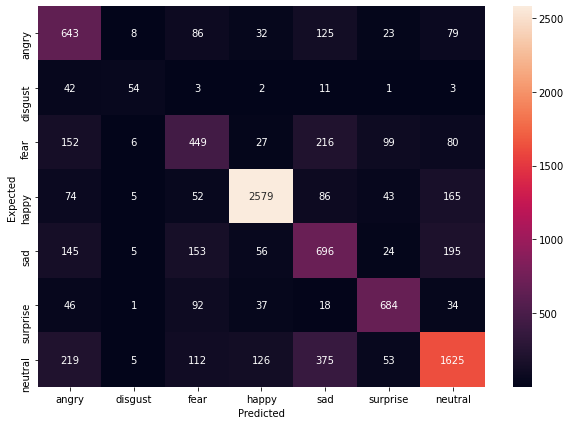

In [ ]:
 class_types = ['angry', 'disgust', 'fear', 'happy', 'sad',
               'surprise', 'neutral']
x_predicted = resnet50_model.predict(x_test)
x_predicted_labels = [np.argmax(i) for i in x_predicted]
cm = tf.math.confusion_matrix(labels=x_test_flattened,predictions=x_predicted_labels)

plt.figure(figsize = (10,7))
sns_hmp = sns.heatmap(cm, annot=True,xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Expected')
#fig = sns_hmp.get_figure()
#fig.savefig('/content/drive/MyDrive/graphs/confusion_matrix', dpi=250)
    


**Testing an image**

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

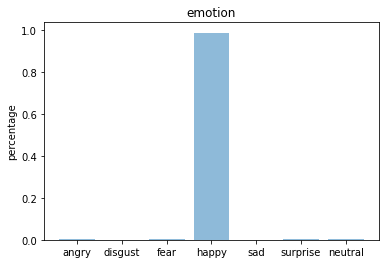

[2.6590331e-03 9.7500655e-05 2.7249758e-03 9.8797041e-01 1.3027841e-03
 2.0205642e-03 3.2246737e-03]
happiness


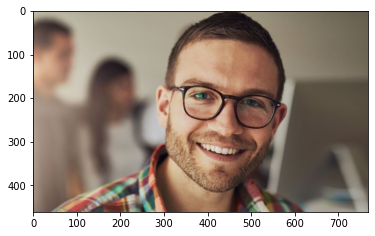

In [ ]:
import cv2
import math
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


d = {0:"angry",1:"disgust",2:"fear",3:"happiness",4:"sad",5:"surprise",6:"neutral"}
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/opencv/haarcascade_frontalface_alt.xml')


file = '/content/drive/MyDrive/Pictures/image_test1.jpg'
true_image = image.load_img(file)
t_image = cv2.imread(file)
#img = image.load_img(file, grayscale=True, target_size=(48, 48))
gray = cv2.cvtColor(t_image,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,4)

if(len(faces) == 0):
    exit()

for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    start_row,end_row,start_col,end_col = y,y+h,x,x+h

croppedimage = gray[start_row:end_row,start_col:end_col]
img = cv2.resize(croppedimage,(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = resnet50_model.predict(x)
emotion_analysis(custom[0])
print(custom[0])

emt = list(custom[0])
idx = emt.index(max(emt))
imgname = d[idx]
print(imgname)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

**Testing a video sample**

In [ ]:
def getFrame(seconds):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,seconds*1000)
    hasFrames,img = vidcap.read()
    
    if hasFrames:
        minutes = "00"
        hours = "00"
        if seconds >= 60:
            minutes = str(seconds//60)
            seconds = seconds % 60

        if int(minutes) >= 60:
            hours = str(int(minutes)//60)
            minutes = str(int(minutes) % 60)

        min = "{:02d}".format(int(minutes))
        sec = "{:02d}".format(seconds)
        hrs = "{:02d}".format(int(hours))

        flag = 0 
        frameId = vidcap.get(1)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,1.1,4)
        
        if(len(faces)==0):
            flag = 1
        
        if flag == 0 :
            global count
            count = count + 1
            for (x,y,w,h) in faces:
                cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
                start_row,end_row,start_col,end_col = y,y+h,x,x+h  
            
            croppedimage = gray[start_row:end_row,start_col:end_col]
            finalimg = cv2.resize(croppedimage,(48,48))

            x = image.img_to_array(finalimg)
            x = np.expand_dims(x, axis = 0)

            x /= 255

            custom = resnet50_model.predict(x)
            emt = list(custom[0])
            idx = emt.index(max(emt))
            imgname = d[idx]
            dcount[imgname] = dcount[imgname] + 1
            
            cv2.imwrite("/content/drive/MyDrive/detection/" + "%d_" % count +imgname+"__"+ hrs+":"+min+":"+sec+".jpg" ,img) 
    
    return hasFrames




In [ ]:
import cv2
import math
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

videoFile = "/content/drive/MyDrive/videosamples/video2.mp4"
vidcap = cv2.VideoCapture(videoFile)

d = {0:"angry",1:"disgust",2:"fear",3:"happiness",4:"sad",5:"surprise",6:"neutral"}
dcount = {"angry":0,"disgust":0,"fear":0,"happiness":0,"sad":0,"surprise":0,"neutral":0}

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/opencv/haarcascade_frontalface_alt.xml')
count = 0

sec = 0
frameRate = 2 #it will capture image in each 2 second
success = getFrame(sec)
while success:
    sec = sec + frameRate
    #sec = round(sec, 2)
    success = getFrame(sec)

print ("Done!")
print("Extracted images:",count)
print(dcount)


Done!
Extracted images: 63
{'angry': 3, 'disgust': 2, 'fear': 2, 'happiness': 10, 'sad': 9, 'surprise': 4, 'neutral': 33}


**Plotting a bar chart of predicted emotions**

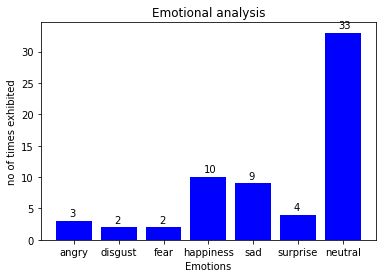

In [ ]:
emotions = list(dcount.keys())
values = list(dcount.values())

fig, ax = plt.subplots() 
width = 0.8
ind = np.arange(len(values)) 

plt.bar(emotions, values, width, color ='blue') 
        
for index, value in enumerate(values): 
    ax.text(index - 0.1, value + 0.70, str(value)) 
  
plt.xlabel("Emotions")
plt.ylabel("no of times exhibited")
plt.title("Emotional analysis")

#plt.savefig('/content/drive/MyDrive/graphs/frequency.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
!pip install python-docx

     |████████████████████████████████| 5.5MB 16.7MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp37-none-any.whl size=184491 sha256=036f83d2e42271c0ee730ffd3d1d2f5e3dd96d47f21563889c70295c1500ade3
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


**Creating a summary report**

In [ ]:
from docx import document

In [ ]:
from docx import Document
from docx.shared import Inches
from docx.shared import RGBColor
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

document = Document()
p1 = document.add_paragraph()
paragraph_format = p1.paragraph_format
paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER
p12 = p1.add_run("REPORT ON EMOTIONS PREDICTED")
f1 = p12.font
f1.size = Pt(16)
f1.underline = True
f1.bold = True

paragraph_format.line_spacing = 1.75

p2 = document.add_paragraph()
p22 = p2.add_run("Name of the video:")
f2 = p22.font
f2.name = 'Calibri'
f2.size = Pt(14)
f2.bold = True
p2.add_run(" video.mp4").font.size = Pt(13)


p3 = document.add_paragraph()
p32 = p3.add_run("Frames extracted link:")
f3 = p32.font
f3.name = 'Calibri'
f3.size = Pt(14)
f3.bold = True
document.add_paragraph('https://drive.google.com/drive/folders/1yw7eNLjjoUXOa2YMe1fFPNPyBuec45dm?usp=sharing')
document.add_paragraph("(Frames are extracted every 2 seconds)")

p4 = document.add_paragraph()
p42 = p4.add_run("Types of emotions predicted")
f4 = p42.font
f4.name = 'Calibri'
f4.size = Pt(14)
f4.bold = True
document.add_paragraph('Angry', style='List Bullet')
document.add_paragraph('Disgust', style='List Bullet')
document.add_paragraph('Fear', style='List Bullet')
document.add_paragraph('Happy', style='List Bullet')
document.add_paragraph('Sad', style='List Bullet')
document.add_paragraph('Surprise', style='List Bullet')
document.add_paragraph('Neutral', style='List Bullet')

p5 = document.add_paragraph()
p52 = p5.add_run("DETAILED ANALYSIS")
f5 = p52.font
f5.size = Pt(14)
f5.underline = True
f5.bold = True

p = document.add_paragraph()
p.add_run('Frequency graph:').bold = True
p.add_run(" No of times the person exhibited a particular emotion")

print("Report created successfully")

document.add_picture('/content/drive/MyDrive/graphs/frequency.png', width=Inches(5.25))
document.save('/content/drive/MyDrive/graphs/emotion_report.docx')






Report created successfully
